# 평가 기준
1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.
    - 구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.
2. Attentional Seq2seq 모델이 정상적으로 구동된다.
    - seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
    - 테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다

# 모듈 임포트

In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import tensorflow as tf
import numpy as np
import pandas as pd

from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker

from tqdm import tqdm
import random
import time
import re
import os
import io

%config InlineBackend.figure_format = 'retina'
 

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# 데이터 불러오기

In [51]:
kor_path = os.getenv('HOME')+'/aiffel/going_deeper/korean-english-park.train.ko'
eng_path = os.getenv('HOME')+'/aiffel/going_deeper/korean-english-park.train.en'

In [52]:
with open(kor_path, "r") as f:
    raw_ko = f.read().splitlines()
            
with open(eng_path, "r") as f:
    raw_en = f.read().splitlines()

In [53]:
print("Data Size:", len(raw_ko))
print("Example:")

for sen in raw_ko[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [54]:
print("Data Size:", len(raw_en))
print("Example:")

for sen in raw_en[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


# 데이터 전처리하기

In [55]:
raw_data = pd.DataFrame({'korea':raw_ko, 'english':raw_en})
raw_data.head()

,korea,english
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


## 1. 중복 제거

In [56]:
print(len(raw_data))

94123


In [57]:
sum(raw_data.duplicated())

15155

두개의 열에 공통으로 중복된 데이터 15,155개가 있는것을 확인하였습니다.

In [58]:
raw_data.drop_duplicates(inplace = True)
print(len(raw_data))

78968


In [59]:
sum(raw_data.duplicated())

0

중복된 데이터를 제거하여 주었습니다.

이제는 각 열에 중복된 데이터가 있는지 확인해주도록 하겠습니다.

In [60]:
sum(raw_data.duplicated(subset='korea'))

1377

In [61]:
sum(raw_data.duplicated(subset='english'))

3370

한국어에는 1377개, 영어는 3370개가 중복이 있는것을 확인하였습니다.

해당 데이터가 무엇인지 확인해보겠습니다.


In [62]:
raw_data[raw_data.duplicated(subset='korea')]

,korea,english
30,어휘 :,Postal Service - whose postmaster told a Senat...
282,어휘 :,the United States will take every measure agai...
1456,어휘 :,aid groups set up freshwater tanks to provide ...
2226,어휘 :,communications with the tiny $4.5 million DASH...
3003,어휘 :,The upper end of that range would put SG344 on...
...,...,...
93891,원문 & 독해설명 인쇄,The per-pack cigarette tax goes from 39 cents ...
94024,TOEIC 독해,The vote is expected late today.
94050,"Bush hails ´major shift´ in Iraq 부시, 이라크에 ‘중대한...",Thousands of Burmese risk the trip to Thailand...
94093,AP 라디오 뉴스입니다.,a national average $2.42 a gallon.


In [63]:
raw_data[raw_data.duplicated(subset='english')]

,korea,english
7218,"신화통신은 중국 당국의 말을 인용, 이번 폭우가 앞으로 10일간 더 쏟아져 언색호 ...",Authorities said that torrential rains are exp...
7219,지난달 2일 리히터 규모 7.9의 대지진으로 이해 아직까지 피해 복구가 진행 중인 ...,The flood has hit nine provinces the hardest &...
8713,미얀마 정부는 총 사망자가 7만8000명이라고 밝힌바 있다.,Myanmar's government has put the death toll at...
8805,‘공포의 7분’이라 불리는 피닉스호의 착륙 과정이 이와 유사한 임무에서 실수를 목격...,"The landing dubbed the ""seven minutes of terro..."
8807,이번 임무를 통제하는 미국 캘리포니아주 패사디나에 위치한 NASA 제트 추진 연구소...,In mission control at NASA's Jet Propulsion La...
...,...,...
94094,"E-1 선거 하루 전, 일반적으로 D-1으로 말하지만 Election 하루 전날을 ...","It's E-1, just one more day until Election Day..."
94095,"outperform (성능을) 능가하다, 여기서는 전세를 뒤집다는 의미.","A drive-by rally just concluded here in Tampa,..."
94096,"Barry Goldwater 베리 골드워터, 애리조나에서",He sounded confident in Cleveland yesterday.
94097,26.2 Miles Through the Streets of New York 이 보...,But our Mark Smith reports the Democrat is try...


한국어에는 '어휘 :'라는 단어가 중복이 되지만, 영어 번역은 다 다르게 되어 있는것을 확인할 수 있습니다.

또한 영어의 경우 'a national average $2.42 a gallon.'라는 중복된 내용이 존재하는데, 이 문장을 해석을 하면 '전국 펴균 갤런당 2달러 42센트'입니다. 하지만 한국어는 'AP 라디오 뉴스입니다.', '저장된 검색어가 없습니다.'로 잘못된 번역으로 데이터가 입력되어 있습니다.

해당 데이터들은 모델 훈련시 노이즈가 될 수 있기 때문에 과감하게 제거해주도록 하겠습니다.


In [64]:
raw_data = raw_data[~raw_data.duplicated(subset='korea')]

In [65]:
raw_data = raw_data[~raw_data.duplicated(subset='english')]

In [66]:
sum(raw_data.duplicated())

0

In [67]:
sum(raw_data.duplicated(subset='korea'))

0

In [68]:
sum(raw_data.duplicated(subset='english'))

0

In [69]:
raw_data = raw_data.reset_index(drop=True)
raw_data

,korea,english
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
74844,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
74845,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
74846,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
74847,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


## 2. 단어 정제

In [21]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?\"\')(.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣0-9?'')(.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [22]:
kor_corpus = []
eng_corpus = []

for sentence in tqdm(raw_data['korea']):
    kor_corpus.append(preprocess_sentence(sentence))
    
for sentence in tqdm(raw_data['english']):
    eng_corpus.append(preprocess_sentence(sentence, s_token=True, e_token=True))

print("한국어:", kor_corpus[50])   
print("영어:", eng_corpus[50])

100%|██████████| 74849/74849 [00:01<00:00, 40591.73it/s]

한국어: 하지만 점점 더 많은 연인들이 웹사이트에 완벽한 축배의 말을 대신 써주도록 의뢰함으로써 그러한 실패로부터 자신들을 보호하고 있다 .
영어: <start> it ' s a wedding couple ' s nightmare , but a growing number of love birds are shielding themselves by having web sites ghostwrite the perfect toast . <end>


## 3. 토큰화

In [23]:
def tokenization(corpus, kor = False, num_words=None):
    if kor:
        mecab = Mecab()
        sentence = []
        for i in tqdm(corpus):
            sentence.append(mecab.morphs(i))
        corpus = sentence
        
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = num_words, filters=' ', char_level=False)
    
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    return tensor, tokenizer

In [24]:
kor_tensor, kor_tokenizer = tokenization(kor_corpus, kor = True, num_words = 20000)
eng_tensor, eng_tokenizer = tokenization(eng_corpus, kor = False, num_words = 20000)

100%|██████████| 74849/74849 [00:11<00:00, 6620.65it/s]


In [25]:
def data_lens(data, name):
    
    print('{} 데이터의 최소 길이 :{}'.format(name, min(len(l) for l in data)))
    print('{} 데이터의 최대 길이 :{}'.format(name, max(len(l) for l in data)))
    print('{} 데이터의 평균 길이 :{}'.format(name, sum(map(len, data))/len(data)))

    plt.hist([len(s) for s in data], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

한국어 데이터의 최소 길이 :0
한국어 데이터의 최대 길이 :127
한국어 데이터의 평균 길이 :29.95420112493153


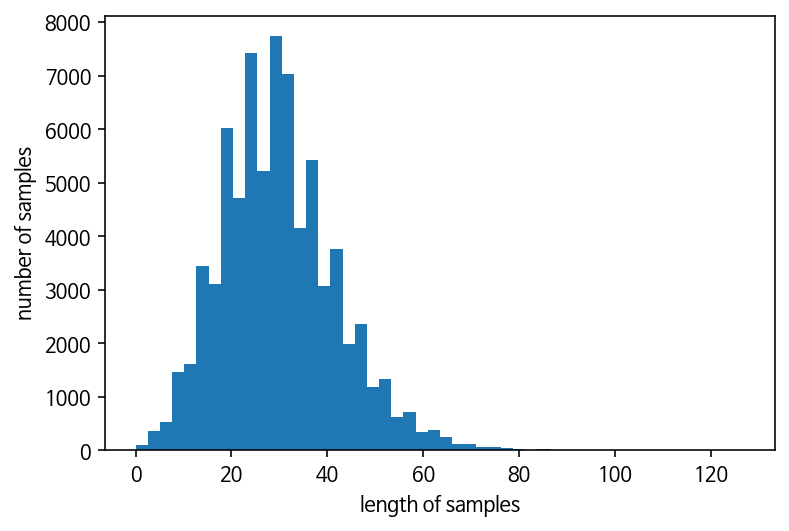

In [26]:
data_lens(kor_tensor, '한국어')

영어 데이터의 최소 길이 :2
영어 데이터의 최대 길이 :103
영어 데이터의 평균 길이 :27.42158211866558


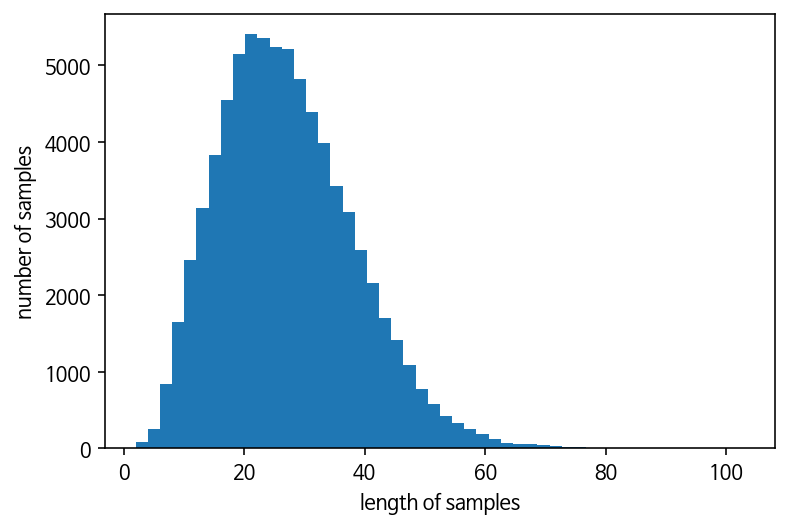

In [27]:
data_lens(eng_tensor, '영어')

In [28]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [29]:
max_len = 45
below_threshold_len(max_len, kor_tensor)

전체 샘플 중 길이가 45 이하인 샘플의 비율: 89.69658913278734


In [30]:
max_len = 45
below_threshold_len(max_len, eng_tensor)

전체 샘플 중 길이가 45 이하인 샘플의 비율: 93.67526620262127


In [31]:
kor_data = tf.keras.preprocessing.sequence.pad_sequences(kor_tensor, padding='post', maxlen= max_len)
eng_data = tf.keras.preprocessing.sequence.pad_sequences(eng_tensor, padding='post', maxlen= max_len)

In [32]:
print(np.shape(kor_data))
print(np.shape(eng_data))

(74849, 45)
(74849, 45)


In [33]:
kor_train, kor_val, eng_train, eng_val = train_test_split(kor_data, eng_data, test_size=0.15)

print(np.shape(kor_train))
print(np.shape(kor_val))
print(np.shape(eng_train))
print(np.shape(eng_val))

(63621, 45)
(11228, 45)
(63621, 45)
(11228, 45)


# 모델 설계

In [46]:
batch_size = 32
vocab_size = 20000
embedding_dim = 128
units = 128
epochs = 30
learning_rate = 1e-5

In [35]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [36]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
        self.gru = tf.keras.layers.GRU(enc_units,return_sequences=True)
        self.dropout = tf.keras.layers.Dropout(0.25)
        self.normalization = tf.keras.layers.LayerNormalization()
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        out = self.dropout(out)
        out = self.normalization(out)
        
        return out

In [40]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.dropout = tf.keras.layers.Dropout(0.25)
        self.normalization = tf.keras.layers.LayerNormalization()
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = self.dropout(out)
        out = self.normalization(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

# 모델 훈련

In [41]:
encoder = Encoder(vocab_size, embedding_dim, units)
decoder = Decoder(vocab_size, embedding_dim, units)

In [42]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [43]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [45]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

In [47]:
for epoch in range(epochs):
    total_loss = 0
    
    idx_list = list(range(0, kor_train.shape[0], batch_size))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_train[idx:idx+batch_size],
                                eng_train[idx:idx+batch_size],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, kor_val.shape[0], batch_size))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(kor_val[idx:idx+batch_size],
                                    eng_val[idx:idx+batch_size],
                                    encoder,
                                    decoder,
                                    eng_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 30: 100%|██████████| 351/351 [00:16<00:00, 21.71it/s, Test Loss 3.0123]


# 평가

In [68]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_train.shape[-1], kor_train.shape[-1]))
   
    sentence = preprocess_sentence(sentence)
    inputs = kor_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=kor_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

# 1차 결과

Input: 내일 시간 있어 ?
Predicted translation: the ? <end> 


/tmp/ipykernel_213/299875125.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_213/299875125.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


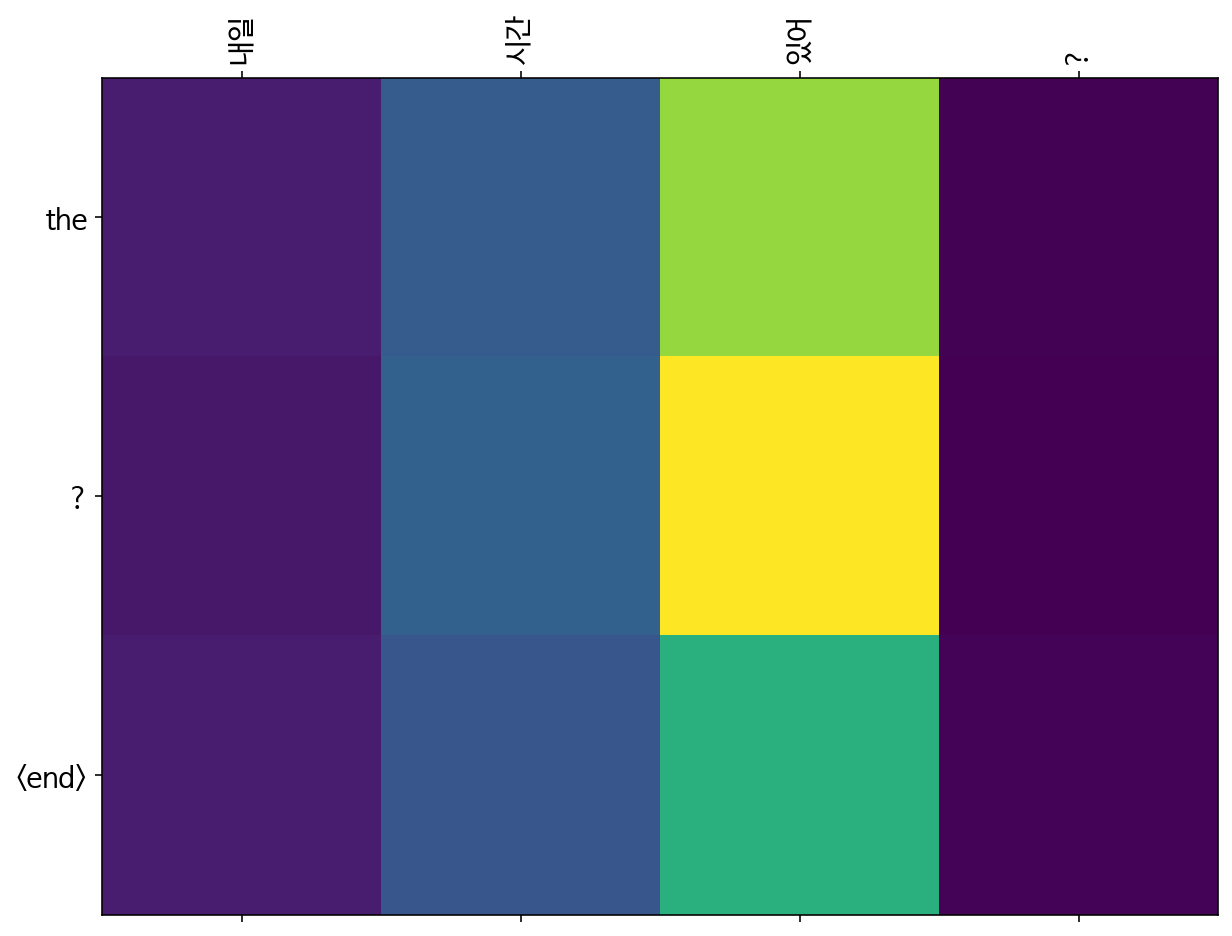

In [69]:
translate("내일 시간 있어?", encoder, decoder)

Input: 영화 보러 갈래 ?
Predicted translation: the ? <end> 


/tmp/ipykernel_213/1366975352.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_213/1366975352.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


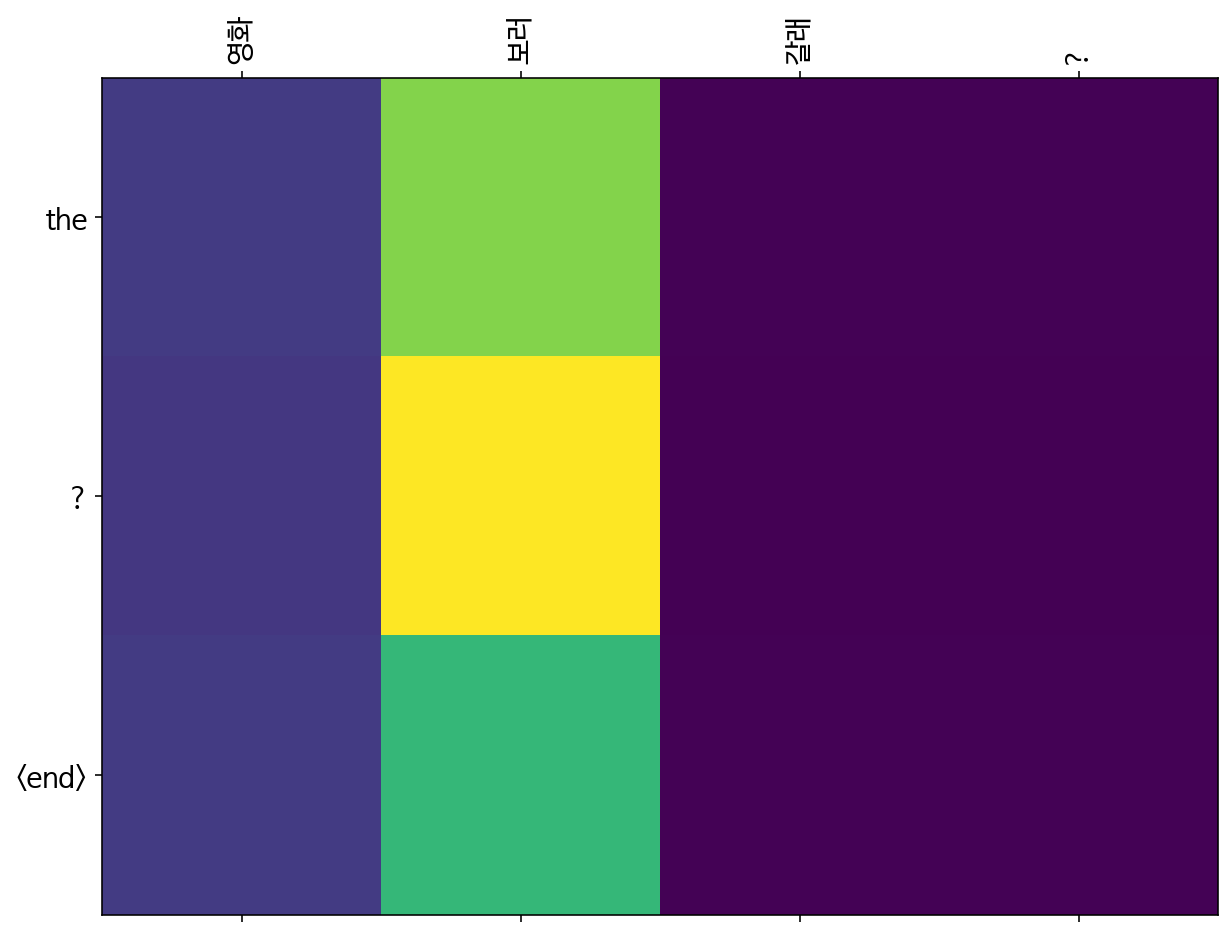

In [62]:
translate("영화 보러 갈래?", encoder, decoder)

## 결과 요약
하이퍼 파라미터
- batch_size = 32
- vocab_size = 20000
- embedding_dim = 128
- units = 128
- epochs = 30
- learning_rate = 1e-5
- train 63621 / val 11228
- max_len = 45

결과를 확인했을때, 번역이 제대로 안된것을 확인할 수 있었습니다.

- 생각하는 이유:
1. 단어 정제시 뉴스 기사 데이터이다 보니 괄호와 '와 같은 따옴표 등을 전처리 하지 않은것이 성능에 안좋은 영향을 끼쳤다고 생각합니다.
2. 훈련 데이터의 갯수도 적었다고 생각합니다.
3. 단어 사전의 경우 2만개로 설정하였는데, 해당 수도 작았다고 생각이 됩니다.

- 이번에는 단어 정제 함수를 수정하고 train데이터의 크기와 사전의 크기도 늘려서 다시 시도해보겠습니다.

----------------------------------------

# 2차 시도

# 전처리 수정

In [70]:
def preprocess_sentence2(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r'\([^)]*\)', r'', sentence) #괄호로 둘러싸인 부분 제거
    sentence = re.sub(r"([0-9?.!,])", r" \1 ", sentence) #문장 내의 구두점을 공백과 함께 분리
    sentence = re.sub(r'[^a-zA-Z가-힣0-9?.!, ]+', r' ', sentence) #영문 알파벳, 한글, 숫자, 구두점을 제외한 모든 문자를 제거
    sentence = re.sub(r"['\n']+", r"", sentence) #개행 문자 제거
    sentence = re.sub(r'["   "]+', " ", sentence) #연속된 공백을 하나의 공백으로 변환

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [71]:
kor_corpus = []
eng_corpus = []

for sentence in tqdm(raw_data['korea']):
    kor_corpus.append(preprocess_sentence2(sentence))
    
for sentence in tqdm(raw_data['english']):
    eng_corpus.append(preprocess_sentence2(sentence, s_token=True, e_token=True))

print("한국어:", kor_corpus[50])   
print("영어:", eng_corpus[50])

100%|██████████| 74849/74849 [00:01<00:00, 45382.79it/s]

한국어: 하지만 점점 더 많은 연인들이 웹사이트에 완벽한 축배의 말을 대신 써주도록 의뢰함으로써 그러한 실패로부터 자신들을 보호하고 있다 . 
영어: <start> it s a wedding couple s nightmare , but a growing number of love birds are shielding themselves by having web sites ghostwrite the perfect toast .  <end>


In [72]:
def tokenization2(corpus, kor = False, num_words=None):
    if kor:
        mecab = Mecab()
        sentence = []
        for i in tqdm(corpus):
            sentence.append(mecab.morphs(i))
        corpus = sentence
        
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = num_words, filters='',oov_token='<unk>')
    
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    return tensor, tokenizer

In [73]:
kor_tensor, kor_tokenizer = tokenization2(kor_corpus, kor = True, num_words = 33000)
eng_tensor, eng_tokenizer = tokenization2(eng_corpus, kor = False, num_words = 33000)

100%|██████████| 74849/74849 [00:10<00:00, 7117.08it/s]


In [76]:
max_len = 45

kor_data = tf.keras.preprocessing.sequence.pad_sequences(kor_tensor, padding='post', maxlen= max_len)
eng_data = tf.keras.preprocessing.sequence.pad_sequences(eng_tensor, padding='post', maxlen= max_len)

In [77]:
print(np.shape(kor_data))
print(np.shape(eng_data))

(74849, 45)
(74849, 45)


# 모델 설계

In [82]:
batch_size = 64
vocab_size = 33000
embedding_dim = 256
units = 256
epochs = 30
learning_rate = 3e-5

In [79]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [80]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
        self.gru = tf.keras.layers.GRU(enc_units,return_sequences=True)
        self.dropout = tf.keras.layers.Dropout(0.25)
        self.normalization = tf.keras.layers.LayerNormalization()
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        out = self.dropout(out)
        out = self.normalization(out)
        
        return out

In [81]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.dropout = tf.keras.layers.Dropout(0.25)
        self.normalization = tf.keras.layers.LayerNormalization()
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = self.dropout(out)
        out = self.normalization(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

# 훈련

In [83]:
encoder = Encoder(vocab_size, embedding_dim, units)
decoder = Decoder(vocab_size, embedding_dim, units)

In [84]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [111]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [112]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_data.shape[-1], kor_data.shape[-1]))
    mecab = Mecab()
    sentence = mecab.morphs(sentence)
    sentence = preprocess_sentence2(sentence)
    inputs = kor_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=kor_data.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_data.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
#     attention = attention[:len(result.split()), :len(sentence.split())]
#     plot_attention(attention, sentence.split(), result.split(' '))

In [88]:
for epoch in range(epochs):
    total_loss = 0
    
    idx_list = list(range(0, kor_data.shape[0], batch_size))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_data[idx:idx+batch_size],
                                eng_data[idx:idx+batch_size],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

Epoch 30: 100%|██████████| 1170/1170 [03:06<00:00,  6.29it/s, Loss 2.1337]


# 2차 결과

In [99]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is the president elect barack obama is the president elect barack obama is the president elect barack obama is the president elect barack obama is the president elect barack obama is the president elect barack obama is the president elect barack obama is the 


In [100]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: they are in cities . <end> 


In [101]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: coffee is no longer . <end> 


In [102]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: seven seven deaths were killed seven seven deaths were killed seven seven deaths were killed seven seven deaths were killed seven seven deaths were killed seven seven deaths were killed seven seven deaths were killed seven seven deaths were killed seven seven deaths were killed 


## 결과 요약
하이퍼 파라미터
- batch_size = 64
- vocab_size = 33000
- embedding_dim = 256
- units = 256
- epochs = 30
- learning_rate = 3e-5
- train 74849
- max_len = 45
- 단어 정제 함수 수정
- tokenization 함수 수정
- evaluate 함수 수정

첫번째보다는 loss값이 많이 떨어졌습니다.

좋은 결과는 아니지만 어느정도의 번역은 해낸것으로 생각됩니다. 첫 모델에서는 evaluate 당시 한글이기때문에 mecab을 이용한 토큰화 과정을 넣어주지 않았는데, 두번째 모델에서는 직접 input으로 받는 질문을 토큰화를 시켜 넣었더니 성능을 낸것으로 확인됩니다. 

이번에는 단어장 수와 learning_rate를 수정하여 시도해보도록 하겠습니다.

------------------------------------------

# 3차 시도

In [103]:
def tokenization2(corpus, kor = False, num_words=None):
    if kor:
        mecab = Mecab()
        sentence = []
        for i in tqdm(corpus):
            sentence.append(mecab.morphs(i))
        corpus = sentence
        
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = num_words, filters='',oov_token='<unk>')
    
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    return tensor, tokenizer

In [105]:
kor_tensor, kor_tokenizer = tokenization2(kor_corpus, kor = True, num_words = 25000)
eng_tensor, eng_tokenizer = tokenization2(eng_corpus, kor = False, num_words = 25000)

100%|██████████| 74849/74849 [00:10<00:00, 7030.57it/s]


In [106]:
max_len = 45

kor_data = tf.keras.preprocessing.sequence.pad_sequences(kor_tensor, padding='post', maxlen= max_len)
eng_data = tf.keras.preprocessing.sequence.pad_sequences(eng_tensor, padding='post', maxlen= max_len)

# 하이퍼 파라미터 수정

In [107]:
batch_size = 64
vocab_size = 25000
embedding_dim = 256
units = 256
epochs = 30
learning_rate = 1e-3

In [108]:
encoder = Encoder(vocab_size, embedding_dim, units)
decoder = Decoder(vocab_size, embedding_dim, units)

In [109]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [113]:
for epoch in range(epochs):
    total_loss = 0
    
    idx_list = list(range(0, kor_data.shape[0], batch_size))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_data[idx:idx+batch_size],
                                eng_data[idx:idx+batch_size],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

Epoch 30: 100%|██████████| 1170/1170 [02:42<00:00,  7.19it/s, Loss 0.5456]


In [116]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_data.shape[-1], kor_data.shape[-1]))
    mecab = Mecab()
    sentence = mecab.morphs(sentence)
    inputs = kor_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=kor_data.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_data.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
#     attention = attention[:len(result.split()), :len(sentence.split())]
#     plot_attention(attention, sentence.split(), result.split(' '))

# 3차 결과

In [117]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is the president . <end> 


In [121]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: civilians are in cities , hurled high of the city . <end> 


In [119]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: there s no idea of the right now . <end> 


In [120]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: seven dead was killed . <end> 


In [133]:
translate("가족을 사랑한다.", encoder, decoder)

Input: ['가족', '을', '사랑', '한다', '.']
Predicted translation: family love love of family . <end> 


In [135]:
translate("오늘 날씨는 덥다.", encoder, decoder)

Input: ['오늘', '날씨', '는', '덥', '다', '.']
Predicted translation: today weather has forced to today <end> 


In [136]:
translate("트럼프는 대통령이다.", encoder, decoder)

Input: ['트럼프', '는', '대통령', '이', '다', '.']
Predicted translation: although donald trump is a statement . <end> 


# 결과 정리
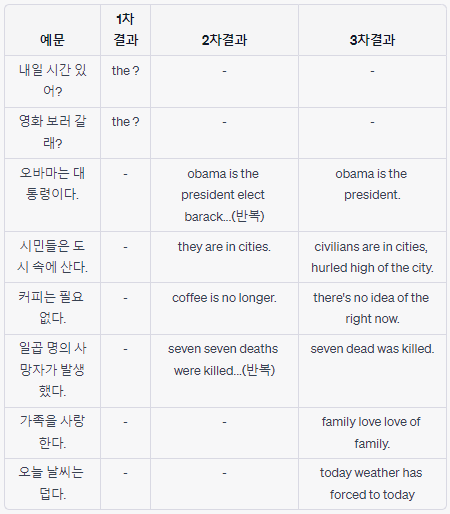
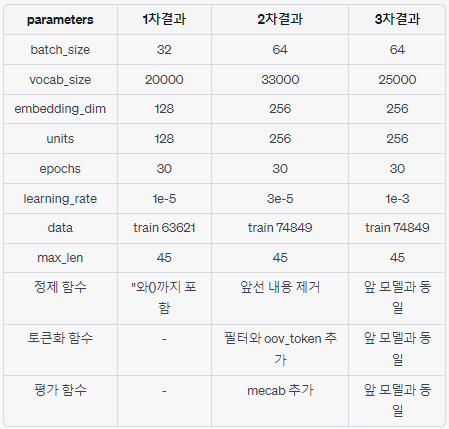

- 오바마는 대통령이다. 라는 문장은 정확하게 번역을 했습니다.
- 완벽한 번역은 아니지만 그래도 일곱명, 사망자, 시민 등 주요 단어들은 제대로 번역한것을 볼 수 있었습니다.

# 전체 회고
- 첫 시도 당시 결과가 안나와 많이 당황했던것 같습니다.
- 하지만 evaluate에서 input으로 예문을 받는데 거기서 mecab이 적용안된것을 보고 2번째부터 적용하였습니다.
- 훈련 데이터도 늘리고, vocab 사이즈도 늘렸더니 어느정도의 결과는 도출되었지만, 같은 문장들이 반복되는것을 확인하였습니다.
- 그래서 이번에는 단어 사이즈를 줄이고, learning_rate를 조금 늘렸더니 제대로 된 번역을 한 문장을 얻을 수 있었습니다.
- 단어장이 많으면 단어를 더 잘 뽑아내겠지라고 생각했지만, 오히려 적은 단어장에서 좋은 번역을 해냈습니다. 단어장이 많다고 무조건 좋은 것은 아니란것을 확인하였습니다.
- 만약 데이터가 더 많았다면 다양한 양질의 데이터를 학습하여 번역의 품질이 높았을 것으로 생각됩니다.


- Luong Attention까지 적용해보고 Bahdanau Attention과의 결과를 비교해보면 좋을것으로 생각됩니다.
- 또한 번역에서는 양방향 모델의 성능이 더 좋은것으로 알려져 있는데, bi-GRU를 시도해보려고 했지만, 실패하였습니다.
- 다음번에는 양방향 모델을 이용한 번역을 공부해보면 좋을것으로 생각됩니다.

# 참고 자료
- 이전 노드
- https://wikidocs.net/78138
- https://wiserloner.tistory.com/1316
- https://wikidocs.net/21698